# LAB 4b:  Create Keras DNN model.

**Learning Objectives**

1. Set CSV Columns, label column, and column defaults
1. Make dataset of features and label from CSV files
1. Create input layers for raw features
1. Create feature columns for inputs
1. Create DNN dense hidden layers and output layer
1. Create custom evaluation metric
1. Build DNN model tying all of the pieces together
1. Train and evaluate


## Introduction 
In this notebook, we'll be using Keras to create a DNN model to predict the weight of a baby before it is born.

We'll start by defining the CSV column names, label column, and column defaults for our data inputs. Then, we'll construct a tf.data Dataset of features and the label from the CSV files and create inputs layers for the raw features. Next, we'll set up feature columns for the model inputs and build a deep neural network in Keras. We'll create a custom evaluation metric and build our DNN model. Finally, we'll train and evaluate our model.

Each learning objective will correspond to a __#TODO__ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/4b_keras_dnn_babyweight.ipynb).

## Load necessary libraries

In [36]:
import datetime
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.1.1


## Verify CSV files exist

In the seventh lab of this series [4a_sample_babyweight](../solutions/4a_sample_babyweight.ipynb), we sampled from BigQuery our train, eval, and test CSV files. Verify that they exist, otherwise go back to that lab and create them.

In [37]:
%%bash
ls *.csv

eval.csv
test.csv
train.csv


In [38]:
%%bash
head -5 *.csv

==> eval.csv <==
6.3118345610599995,Unknown,35,Single(1),38
5.43659938092,Unknown,21,Multiple(2+),35
7.43839671988,Unknown,20,Single(1),40
6.37576861704,Unknown,27,Multiple(2+),34
7.62358501996,True,30,Single(1),38

==> test.csv <==
6.9996768185,Unknown,20,Single(1),39
6.9996768185,Unknown,26,Single(1),37
7.93443680938,Unknown,25,Single(1),39
5.5005334369,Unknown,35,Single(1),34
7.31052860792,Unknown,26,Single(1),39

==> train.csv <==
6.1883756943399995,Unknown,24,Single(1),38
9.39389698382,Unknown,25,Single(1),38
7.81318256528,Unknown,32,Single(1),41
6.75055446244,True,21,Single(1),36
8.12623897732,True,34,Single(1),40


## Create Keras model

### Lab Task #1: Set CSV Columns, label column, and column defaults.

Now that we have verified that our CSV files exist, we need to set a few things that we will be using in our input function.
* `CSV_COLUMNS` are going to be our header names of our columns. Make sure that they are in the same order as in the CSV files
* `LABEL_COLUMN` is the header name of the column that is our label. We will need to know this to pop it from our features dictionary.
* `DEFAULTS` is a list with the same length as `CSV_COLUMNS`, i.e. there is a default for each column in our CSVs. Each element is a list itself with the default value for that CSV column.

In [39]:
# Determine CSV, label, and key columns
# TODO: Create list of string column headers, make sure order matches.
# JOSE: weight_pounds is_male mother_age plurality gestation_weeks hash_values
CSV_COLUMNS = ["weight_pounds", "is_male", "mother_age", "plurality", "gestation_weeks"]

# TODO: Add string name for label column
LABEL_COLUMN = "weight_pounds"

# Set default values for each CSV column as a list of lists.
# Treat is_male and plurality as strings.
DEFAULTS = [[0.0], ["null"], [0.0], ["null"], [0.0]]

### Lab Task #2: Make dataset of features and label from CSV files.

Next, we will write an input_fn to read the data. Since we are reading from CSV files we can save ourself from trying to recreate the wheel and can use `tf.data.experimental.make_csv_dataset`. This will create a CSV dataset object. However we will need to divide the columns up into features and a label. We can do this by applying the map method to our dataset and popping our label column off of our dictionary of feature tensors.

In [40]:
def features_and_labels(row_data):
    """Splits features and labels from feature dictionary.

    Args:
        row_data: Dictionary of CSV column names and tensor values.
    Returns:
        Dictionary of feature tensors and label tensor.
    """
    label = row_data.pop(LABEL_COLUMN)

    return row_data, label  # features, label


def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
    """Loads dataset using the tf.data API from CSV files.

    Args:
        pattern: str, file pattern to glob into list of files.
        batch_size: int, the number of examples per batch.
        mode: tf.estimator.ModeKeys to determine if training or evaluating.
    Returns:
        `Dataset` object.
    """
    # TODO: Make a CSV dataset
    dataset = tf.data.experimental.make_csv_dataset(
        file_pattern=pattern,
        batch_size=batch_size,
        column_names=CSV_COLUMNS,
        column_defaults=DEFAULTS)

    # TODO: Map dataset to features and label
    dataset = dataset.map(map_func=features_and_labels)  # features, label

    # Shuffle and repeat for training
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # Take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

### Lab Task #3: Create input layers for raw features.

We'll need to get the data read in by our input function to our model function, but just how do we go about connecting the dots? We can use Keras input layers [(tf.Keras.layers.Input)](https://www.tensorflow.org/api_docs/python/tf/keras/Input) by defining:
* shape: A shape tuple (integers), not including the batch size. For instance, shape=(32,) indicates that the expected input will be batches of 32-dimensional vectors. Elements of this tuple can be None; 'None' elements represent dimensions where the shape is not known.
* name: An optional name string for the layer. Should be unique in a model (do not reuse the same name twice). It will be autogenerated if it isn't provided.
* dtype: The data type expected by the input, as a string (float32, float64, int32...)

In [43]:
def create_input_layers():
    """Creates dictionary of input layers for each feature.

    Returns:
        Dictionary of `tf.Keras.layers.Input` layers for each feature.
    """
    # TODO: Create dictionary of tf.keras.layers.Input for each raw feature
    #"weight_pounds":LABEL, "is_male", "mother_age", "plurality", "gestation_weeks"
    inputs = {
        colname: tf.keras.layers.Input(
            name=colname, shape=(), dtype="float32")
        for colname in ["mother_age", "gestation_weeks"]}
    
    inputs.update({
        colname: tf.keras.layers.Input(
            name=colname, shape=(), dtype="string")
        for colname in ["is_male", "plurality"]})

    return inputs

### Lab Task #4: Create feature columns for inputs.

Next, define the feature columns. `mother_age` and `gestation_weeks` should be numeric. The others, `is_male` and `plurality`, should be categorical. Remember, only dense feature columns can be inputs to a DNN.

In [44]:
def categorical_fc(name, values):

    cat_column = tf.feature_column.categorical_column_with_vocabulary_list(
        key=name, vocabulary_list=values)
    
    return tf.feature_column.indicator_column(categorical_column=cat_column)


def create_feature_columns():
    """Creates dictionary of feature columns from inputs.

    Returns:
        Dictionary of feature columns.
    """
    # TODO: Create feature columns for numeric features
    feature_columns = {
        colname : tf.feature_column.numeric_column(key=colname)
           for colname in ["mother_age", "gestation_weeks"]}

    # TODO: Add feature columns for categorical features
    feature_columns["is_male"] = categorical_fc(
        "is_male", ["True", "False", "Unknown"])
    feature_columns["plurality"] = categorical_fc(
        "plurality", ["Single(1)", "Twins(2)", "Triplets(3)", "Quadruplets(4)", "Quintuplets(5)", "Multiple(2+)"])
    
    return feature_columns

### Lab Task #5: Create DNN dense hidden layers and output layer.

So we've figured out how to get our inputs ready for machine learning but now we need to connect them to our desired output. Our model architecture is what links the two together. Let's create some hidden dense layers beginning with our inputs and end with a dense output layer. This is regression so make sure the output layer activation is correct and that the shape is right.

In [45]:
def get_model_outputs(inputs):
    """Creates model architecture and returns outputs.

    Args:
        inputs: Dense tensor used as inputs to model.
    Returns:
        Dense tensor output from the model.
    """
    # TODO: Create two hidden layers of [64, 32] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(64, activation="relu", name="h1")(inputs)
    h2 = tf.keras.layers.Dense(32, activation="relu", name="h2")(h1)

    # TODO: Create final output layer
    output = tf.keras.layers.Dense(units=1, activation="linear", name="weight")(h2)

    return output

### Lab Task #6: Create custom evaluation metric.

We want to make sure that we have some useful way to measure model performance for us. Since this is regression, we would like to know the RMSE of the model on our evaluation dataset, however, this does not exist as a standard evaluation metric, so we'll have to create our own by using the true and predicted labels.

In [46]:
def rmse(y_true, y_pred):
    """Calculates RMSE evaluation metric.

    Args:
        y_true: tensor, true labels.
        y_pred: tensor, predicted labels.
    Returns:
        Tensor with value of RMSE between true and predicted labels.
    """
    # TODO: Calculate RMSE from true and predicted labels
    return tf.sqrt(tf.reduce_mean((y_pred-y_true)**2))

### Lab Task #7: Build DNN model tying all of the pieces together.

Excellent! We've assembled all of the pieces, now we just need to tie them all together into a Keras Model. This is a simple feedforward model with no branching, side inputs, etc. so we could have used Keras' Sequential Model API but just for fun we're going to use Keras' Functional Model API. Here we will build the model using [tf.keras.models.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) giving our inputs and outputs and then compile our model with an optimizer, a loss function, and evaluation metrics.

In [47]:
# Build a simple Keras DNN using its Functional API
def build_dnn_model():
    """Builds simple DNN using Keras Functional API.

    Returns:
        `tf.keras.models.Model` object.
    """
    # Create input layer
    inputs = create_input_layers()

    # Create feature columns
    feature_columns = create_feature_columns()

    # The constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires: LayerConstructor()(inputs)
    dnn_inputs = tf.keras.layers.DenseFeatures(
        feature_columns=feature_columns.values())(inputs)

    # Get output of model given inputs
    output = get_model_outputs(dnn_inputs)

    # Build model and compile it all together
    model = tf.keras.models.Model(inputs=inputs, outputs=output)

    # TODO: Add custom eval metrics to list
    model.compile(optimizer="adam", loss="mse", metrics=["mse", rmse])#rmse añadido a metrics en el último corchete

    return model

print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
print(model.summary())

Here is our DNN architecture so far:

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gestation_weeks (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
is_male (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
mother_age (InputLayer)         [(None,)]            0                                            
______

We can visualize the DNN using the Keras plot_model utility.

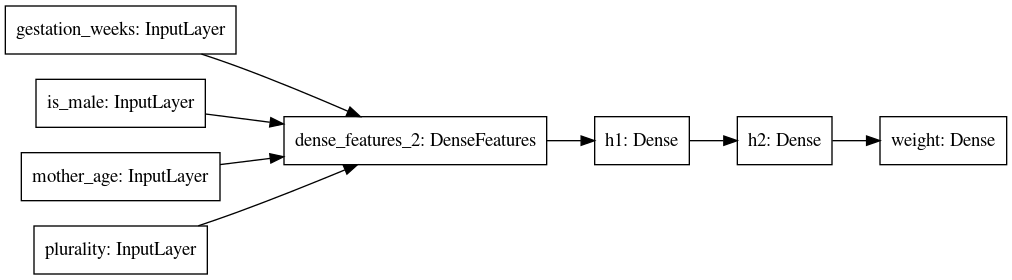

In [48]:
tf.keras.utils.plot_model(
    model=model, to_file="dnn_model.png", show_shapes=False, rankdir="LR")

## Run and evaluate model

### Lab Task #8: Train and evaluate.

We've built our Keras model using our inputs from our CSV files and the architecture we designed. Let's now run our model by training our model parameters and periodically running an evaluation to track how well we are doing on outside data as training goes on. We'll need to load both our train and eval datasets and send those to our model through the fit method. Make sure you have the right pattern, batch size, and mode when loading the data. Also, don't forget to add the callback to TensorBoard.

In [53]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset repeats, it'll wrap around
NUM_EVALS = 5  # how many times to evaluate
# Enough to get a reasonable sample, but not so much that it slows down
NUM_EVAL_EXAMPLES = 10000

# TODO: Load training dataset
trainds = load_dataset(
    pattern="train*",
    batch_size=TRAIN_BATCH_SIZE,
    mode=tf.estimator.ModeKeys.TRAIN)

# TODO: Load evaluation dataset
evalds = load_dataset(
    pattern="eval*",
    batch_size=1000,
    mode=tf.estimator.ModeKeys.EVAL).take(count=NUM_EVAL_EXAMPLES // 1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

logdir = os.path.join(
    "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir, histogram_freq=1)

# TODO: Fit model on training dataset and evaluate every so often
history = model.fit(
    trainds,
    validation_data=evalds,
    epochs=NUM_EVALS,
    steps_per_epoch=steps_per_epoch,
    callbacks=[tensorboard_callback])

Train for 312 steps, validate for 10 steps
Epoch 1/5
312/312 [==============================] - 3s 9ms/step - loss: 1.1846 - mse: 1.1846 - rmse: 1.0758 - val_loss: 1.2225 - val_mse: 1.2225 - val_rmse: 1.1054
Epoch 2/5
312/312 [==============================] - 3s 8ms/step - loss: 1.1801 - mse: 1.1801 - rmse: 1.0752 - val_loss: 1.2288 - val_mse: 1.2288 - val_rmse: 1.1082
Epoch 3/5
312/312 [==============================] - 2s 8ms/step - loss: 1.1491 - mse: 1.1491 - rmse: 1.0604 - val_loss: 1.0987 - val_mse: 1.0987 - val_rmse: 1.0480
Epoch 4/5
312/312 [==============================] - 2s 7ms/step - loss: 1.1322 - mse: 1.1322 - rmse: 1.0531 - val_loss: 1.1011 - val_mse: 1.1011 - val_rmse: 1.0491
Epoch 5/5
312/312 [==============================] - 3s 10ms/step - loss: 1.1178 - mse: 1.1178 - rmse: 1.0462 - val_loss: 1.1198 - val_mse: 1.1198 - val_rmse: 1.0581


### Visualize loss curve

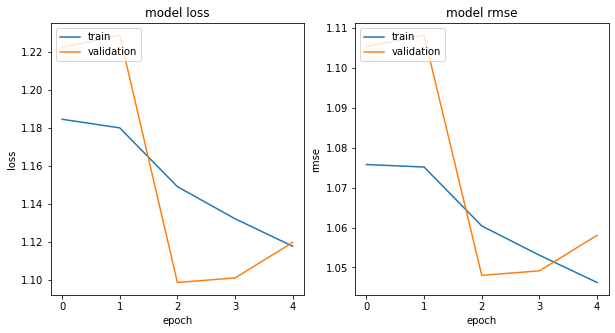

In [56]:
# Plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(["loss", "rmse"]):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history["val_{}".format(key)])
    plt.title("model {}".format(key))
    plt.ylabel(key)
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left");

### Save the model

In [57]:
OUTPUT_DIR = "babyweight_trained"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(
    OUTPUT_DIR, datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
tf.saved_model.save(
    obj=model, export_dir=EXPORT_PATH)  # with default serving function
print("Exported trained model to {}".format(EXPORT_PATH))

AttributeError: 'Operation' object has no attribute '_graph'

In [52]:
!ls $EXPORT_PATH

assets	saved_model.pb	variables


## Lab Summary: 
In this lab, we started by defining the CSV column names, label column, and column defaults for our data inputs. Then, we constructed a tf.data Dataset of features and the label from the CSV files and created inputs layers for the raw features. Next, we set up feature columns for the model inputs and built a deep neural network in Keras. We created a custom evaluation metric and built our DNN model. Finally, we trained and evaluated our model.

Copyright 2020 Google LLC
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
    https://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.